In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import os
import geopandas as gpd

In [2]:
path_t = ""
dir_t_list = os.listdir(path_t)

path_r = ""
dir_r_list = os.listdir(path_r)

In [3]:
temp = []

for i in range(1980,2016,5):
    current_10_temp = []
    for j in range(0,10):
        current_temp = pd.read_csv(path_t+'/OBS_ASOS_TIM_' + str(i+j) + '.csv', encoding='cp949')
        current_10_temp.append(current_temp)
    temp.append(current_10_temp)

    
rain = []

for i in range(1980,2016,5):
    current_10_rain = []
    for j in range(0,10):
        current_rain = pd.read_csv(path_r+'/OBS_ASOS_TIM_rain_' + str(i+j) + '.csv', encoding='cp949')
        current_10_rain.append(current_rain)
    rain.append(current_10_rain)
    

print(len(temp))
print(len(rain))

8
8


In [4]:
siteset = ['속초','대관령','강릉','울진','포항','영덕','춘천','서울','인천','원주','수원','충주','서산','청주','대전','양평','이천','인제','홍천','제천','보은','보령','부여','금산','추풍령','군산','대구','전주','울산','광주','부산','통영','목포','여수','완도','제주','성산','서귀포','진주','강화','천안','부안','임실','정읍','남원','해남','고흥','영주','문경','의성','구미','영천','거창','합천','밀양','산청','거제','남해']

In [5]:
def KoppenClassification_V(tempData, rainData):
    values = {}
    
    #monthly average precipitation
    rainData.columns = rainData.columns.str.strip()
    rainData['일시'] = pd.to_datetime(rainData['일시'])
    rainData['강수량(mm)'] = rainData['강수량(mm)'].fillna(0)

    rainData['연월'] = rainData['일시'].dt.to_period('M')

    daily_rain = rainData.groupby(rainData['일시'].dt.date)['강수량(mm)'].sum().reset_index()
    daily_rain['연월'] = pd.to_datetime(daily_rain['일시']).dt.to_period('M')

    monthly_total = daily_rain.groupby('연월')['강수량(mm)'].sum()   #monthly total

    days_per_month = daily_rain.groupby('연월')['일시'].nunique()    #days per month

    monthly_avg_rain_list = (monthly_total / days_per_month).tolist()     #average rain list
    
    values['monthly_avg_rain_list'] = monthly_avg_rain_list
    
    #월평균기온(리스트)
    tempData.columns = tempData.columns.str.strip()
    tempData['일시'] = pd.to_datetime(tempData['일시'])

    tempData['일자'] = tempData['일시'].dt.date

    daily_avg_temp = tempData.groupby('일자')['기온(°C)'].mean().reset_index()
    
    daily_avg_temp['연월'] = pd.to_datetime(daily_avg_temp['일자']).dt.to_period('M')

    monthly_avg_temp_from_daily = daily_avg_temp.groupby('연월')['기온(°C)'].mean()

    monthly_avg_temp_list = monthly_avg_temp_from_daily.tolist()
    
    annual_av_temp = sum(monthly_avg_temp_list)/len(monthly_avg_temp_list)
    
    values['annual_av_temp'] = annual_av_temp
    
    values['monthly_avg_temp_list'] = monthly_avg_temp_list
    
    #최한월기온
    coldest_av_temp = min(monthly_avg_temp_list)
    
    values['coldest_av_temp'] = coldest_av_temp

    #최난월기온
    warmest_av_temp = max(monthly_avg_temp_list)
    
    values['warmest_av_temp'] = warmest_av_temp

    #연강수량
    rainData.columns = rainData.columns.str.strip()
    rainData['일시'] = pd.to_datetime(rainData['일시'])
    rainData['일자'] = rainData['일시'].dt.date
    daily_rain = rainData.groupby('일자')['강수량(mm)'].sum()

    annual_precipitation_amount = daily_rain.sum()
    
    values['annual_precipitation_amount'] = annual_precipitation_amount

    #threshold1
    rainData['일시'] = pd.to_datetime(rainData['일시'])
    rainData['월'] = rainData['일시'].dt.month
    
    annual_avg_temp = tempData['기온(°C)'].mean()
    
    april_to_september_precip = rainData[rainData['월'].between(4, 9)]['강수량(mm)'].sum()
    
    summer_ratio = april_to_september_precip / annual_precipitation_amount
    
    if summer_ratio >= 0.7:
        add = 140
    elif summer_ratio >= 0.3:
        add = 70
    else:
        add = 0
        
    threshold1 = annual_avg_temp*10+add
    
    values['threshold1'] = threshold1
    
    #threshold2
    rainData['일시'] = pd.to_datetime(rainData['일시'])
    rainData['월'] = rainData['일시'].dt.month
    
    annual_avg_temp = tempData['기온(°C)'].mean()
    
    april_to_september_precip = rainData[rainData['월'].between(4, 9)]['강수량(mm)'].sum()
        
    values['april_to_september_precip'] = april_to_september_precip
    
    if summer_ratio >= 0.7:
        add2 = 280
    elif summer_ratio >= 0.3:
        add2 = 140
    else:
        add2 = 0
        
    threshold2 = annual_avg_temp*20+add2
    
    values['threshold2'] = threshold2

    wettest_month_list = monthly_avg_rain_list[0:2]
    wettest_month_list.append(monthly_avg_rain_list[-1])
    wettest_month_122 = max(wettest_month_list)
    
    values['wettest_month_122'] = wettest_month_122
    
    driest_month_68 = min(monthly_avg_rain_list[5:8])
    
    values['driest_month_68'] = driest_month_68
    
    driest_month_list = monthly_avg_rain_list[0:2]
    driest_month_list.append(monthly_avg_rain_list[-1])
    driest_month_122 = min(driest_month_list)
    
    values['driest_month_122'] = driest_month_122

    wettest_month_68 = max(monthly_avg_rain_list[5:8])
    
    values['wettest_month_68'] = wettest_month_68

    count_10 = sum(1 for t in monthly_avg_temp_list if t > 10)

    values['count_10'] = count_10
    
    return values

In [6]:
def tenYearVariables(valuesList):
    tenYearVariable = {}

    #10년 최한월 평균
    coldestTen = []
    for i in range(0,10):
        coldestTen.append(valuesList[i]['coldest_av_temp'])
    coldest_av_temp_10 = sum(coldestTen)/len(coldestTen)

    tenYearVariable['coldest_av_temp_10'] = coldest_av_temp_10

    #10년 최난월 평균
    warmestTen = []
    for i in range(0,10):
        warmestTen.append(valuesList[i]['warmest_av_temp'])
    warmest_av_temp_10 = sum(warmestTen)/len(warmestTen)

    tenYearVariable['warmest_av_temp_10'] = warmest_av_temp_10

    #10년 연평균 강수량
    annualRainTen = []
    for i in range(0,10):
        annualRainTen.append(valuesList[i]['annual_precipitation_amount'])
    annual_precipitation_amount_10 = sum(annualRainTen)/len(annualRainTen)

    tenYearVariable['annual_precipitation_amount_10'] = annual_precipitation_amount_10

    #10년 연평균 기온
    annualTempTen = []
    for i in range(0,10):
        annualTempTen.append(valuesList[i]['annual_av_temp'])
    annual_av_temp_10 = sum(annualTempTen)/len(annualTempTen)

    tenYearVariable['annual_av_temp_10'] = annual_av_temp_10

    #10년 AprilSeptember
    annualAprSep = []
    for i in range(0,10):
        annualAprSep.append(valuesList[i]['april_to_september_precip'])
    annualAprSep_10 = sum(annualAprSep)/len(annualAprSep)

    tenYearVariable['annualAprSep_10'] = annualAprSep_10

    #threshold1_10
    summer_ratio = annualAprSep_10 / annual_precipitation_amount_10
    if summer_ratio >= 0.7:
        add = 140
    elif summer_ratio >= 0.3:
        add = 70
    else:
        add = 0

    threshold1_10 = annual_av_temp_10*10+add
    tenYearVariable['threshold1_10'] = threshold1_10


    #threshold2_10
    if summer_ratio >= 0.7:
        add2 = 280
    elif summer_ratio >= 0.3:
        add2 = 140
    else:
        add2 = 0
    threshold2_10 = annual_av_temp_10*20+add2
    tenYearVariable['threshold2_10'] = threshold2_10

    #wettest_month_122_10
    wettest_month_122_10_List = []
    for i in range(0,10):
        wettest_month_122_10_List.append(valuesList[i]['wettest_month_122'])
    wettest_month_122_10 = sum(wettest_month_122_10_List)/len(wettest_month_122_10_List)

    tenYearVariable['wettest_month_122_10'] = wettest_month_122_10

    #driest_month_122_10
    driest_month_122_10_List = []
    for i in range(0,10):
        driest_month_122_10_List.append(valuesList[i]['driest_month_122'])
    driest_month_122_10 = sum(driest_month_122_10_List)/len(driest_month_122_10_List)

    tenYearVariable['driest_month_122_10'] = driest_month_122_10

    #wettest_month_68_10
    wettest_month_68_10_List = []
    for i in range(0,10):
        wettest_month_68_10_List.append(valuesList[i]['wettest_month_68'])
    wettest_month_68_10 = sum(wettest_month_68_10_List)/len(wettest_month_68_10_List)

    tenYearVariable['wettest_month_68_10'] = wettest_month_68_10

    #driest_month_68_10
    driest_month_68_10_List = []
    for i in range(0,10):
        driest_month_68_10_List.append(valuesList[i]['driest_month_68'])
    driest_month_68_10 = sum(driest_month_68_10_List)/len(driest_month_68_10_List)

    tenYearVariable['driest_month_68_10'] = driest_month_68_10

    #count_10_10
    count_10_lists = []
    for i in range(0,10):
        count_10_lists.append(valuesList[i]['monthly_avg_temp_list'])
    monthly_avg_temp_list_10 = [sum(values) / 10 for values in zip(*count_10_lists)]
    count_10_10 = sum(1 for t in monthly_avg_temp_list_10 if t > 10)
    tenYearVariable['count_10_10'] = count_10_10

    
    return tenYearVariable

In [9]:
def tenYearVariables(valuesList):
    tenYearVariable = {}

    coldestTen = [v['coldest_av_temp'] for v in valuesList]
    warmestTen = [v['warmest_av_temp'] for v in valuesList]
    annualRainTen = [v['annual_precipitation_amount'] for v in valuesList]
    annualTempTen = [v['annual_av_temp'] for v in valuesList]
    annualAprSep = [v['april_to_september_precip'] for v in valuesList]

    tenYearVariable['coldest_av_temp_10'] = sum(coldestTen) / len(coldestTen)
    tenYearVariable['warmest_av_temp_10'] = sum(warmestTen) / len(warmestTen)
    tenYearVariable['annual_precipitation_amount_10'] = sum(annualRainTen) / len(annualRainTen)
    tenYearVariable['annual_av_temp_10'] = sum(annualTempTen) / len(annualTempTen)
    tenYearVariable['annualAprSep_10'] = sum(annualAprSep) / len(annualAprSep)

    summer_ratio = tenYearVariable['annualAprSep_10'] / tenYearVariable['annual_precipitation_amount_10']
    tenYearVariable['threshold1_10'] = tenYearVariable['annual_av_temp_10'] * 10 + (140 if summer_ratio >= 0.7 else 70 if summer_ratio >= 0.3 else 0)
    tenYearVariable['threshold2_10'] = tenYearVariable['annual_av_temp_10'] * 20 + (280 if summer_ratio >= 0.7 else 140 if summer_ratio >= 0.3 else 0)

    tenYearVariable['wettest_month_122_10'] = sum([v['wettest_month_122'] for v in valuesList]) / len(valuesList)
    tenYearVariable['driest_month_122_10'] = sum([v['driest_month_122'] for v in valuesList]) / len(valuesList)
    tenYearVariable['wettest_month_68_10'] = sum([v['wettest_month_68'] for v in valuesList]) / len(valuesList)
    tenYearVariable['driest_month_68_10'] = sum([v['driest_month_68'] for v in valuesList]) / len(valuesList)

    monthly_temp_lists = [v['monthly_avg_temp_list'] for v in valuesList if 'monthly_avg_temp_list' in v]
    avg_monthly = [sum(x) / len(x) for x in zip(*monthly_temp_lists)]
    tenYearVariable['count_10_10'] = sum(1 for t in avg_monthly if t > 10)

    return tenYearVariable


In [10]:
def KoppenClassification_10y_variable(result):
    koppen_list = []

    for tenYearVariable in result:
        coldest_av_temp = tenYearVariable['coldest_av_temp_10']
        warmest_av_temp = tenYearVariable['warmest_av_temp_10']
        annual_precipitation_amount = tenYearVariable['annual_precipitation_amount_10']
        threshold1 = tenYearVariable['threshold1_10']
        threshold2 = tenYearVariable['threshold2_10']
        wettest_month_122 = tenYearVariable['wettest_month_122_10']
        driest_month_122 = tenYearVariable['driest_month_122_10']
        wettest_month_68 = tenYearVariable['wettest_month_68_10']
        driest_month_68 = tenYearVariable['driest_month_68_10']
        count_10 = tenYearVariable['count_10_10']

        # A
        if coldest_av_temp > 18:
            if annual_precipitation_amount > threshold1:
                koppen_list.append("A")
                continue

        # B
        if threshold1<annual_precipitation_amount < threshold2:
            koppen_list.append("BW")
            continue
        elif annual_precipitation_amount < threshold1:
            koppen_list.append("BS")
            continue

        # C
        if -3 < coldest_av_temp < 18:
            if annual_precipitation_amount > threshold1:
                if wettest_month_122 > 3 * driest_month_68:
                    koppen_list.append("Cs")
                    continue
                elif wettest_month_68 > driest_month_122 * 10:
                    koppen_list.append("Cw")
                    continue
                elif warmest_av_temp > 22:
                    koppen_list.append("Cfa")
                    continue
                elif warmest_av_temp < 22:
                    if count_10 >= 4:
                        koppen_list.append("Cfb")
                        continue
                    elif 1 <= count_10 <= 3 and coldest_av_temp > -38:
                        koppen_list.append("Cfc")
                        continue

        # D
        if warmest_av_temp > 10 and coldest_av_temp <= -3:
            if annual_precipitation_amount > threshold1:
                if wettest_month_68 > 10 * driest_month_122:
                    koppen_list.append("Dw")
                    continue
                elif warmest_av_temp > 22:
                    koppen_list.append("Dfa")
                    continue
                elif warmest_av_temp < 22:
                    if count_10 >= 4:
                        koppen_list.append("Dfb")
                        continue
                    elif 1 <= count_10 <= 3 and coldest_av_temp > -38:
                        koppen_list.append("Dfc")
                        continue

        # E
        if warmest_av_temp < 10:
            koppen_list.append("E")
            continue

        # 기타 분류 실패한 경우
        koppen_list.append("Unclassified")

    return koppen_list


In [11]:
def Koppen(region):
    region_temp_list = []
    for group in temp:
        region_temp_list.append([df[df['지점명'] == region].copy() for df in group])

    region_rain_list = []
    for group in rain:
        region_rain_list.append([df[df['지점명'] == region].copy() for df in group])

    valuesList = []
    for temp_group, rain_group in zip(region_temp_list, region_rain_list):
        values = [KoppenClassification_V(t, r) for t, r in zip(temp_group, rain_group)]
        valuesList.append(values)

    ten_year_results = [tenYearVariables(v) for v in valuesList]
    return KoppenClassification_10y_variable(ten_year_results)

In [12]:
siteset = ['속초','대관령','강릉','울진','포항','영덕','춘천','서울','인천','원주','수원','충주','서산','청주','대전','양평','이천','인제','홍천','제천','보은','보령','부여','금산','추풍령','군산','대구','전주','울산','광주','부산','통영','목포','여수','완도','제주','성산','서귀포','진주','강화','천안','부안','임실','정읍','남원','해남','고흥','영주','문경','의성','구미','영천','거창','합천','밀양','산청','거제','남해']

In [13]:
for i in siteset:
    print(i,Koppen(i))

속초 ['Cw', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw']
대관령 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw']
강릉 ['Cw', 'Cfa', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cfa', 'Cw']
울진 ['Cfa', 'Cfa', 'Cfa', 'Cfa', 'Cw', 'Cfa', 'Cfa', 'Cfa']
포항 ['Cfa', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cfa', 'Cfa', 'Cw']
영덕 ['Cw', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa', 'Cw']
춘천 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw']
서울 ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Cw']
인천 ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw']
원주 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Cw']
수원 ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Cw']
충주 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw']
서산 ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw']
청주 ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw']
대전 ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw']
양평 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Cw']
이천 ['Dw', 'Dw', 'Cw', 'Dw', 'Dw', 'Dw', 'Dw', 'Cw']
인제 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw']
홍천 ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'D

In [14]:
map_path = '/Users/jeong-ina/Downloads/법정구역 GeoJSON 데이터_23년8월/법정구역_시군구.geojson'
korea_map = gpd.read_file(map_path).to_crs("EPSG:4326")

In [15]:
location_dict = {
    '속초': (38.2044, 128.5911),
    '대관령': (37.6775, 128.7051),
    '강릉': (37.7519, 128.8761),
    '울진': (37.0002, 129.4000),
    '포항': (36.0190, 129.3435),
    '영덕': (36.4156, 129.3656),
    '춘천': (37.8813, 127.7298),
    '서울': (37.5665, 126.9780),
    '인천': (37.4563, 126.7052),
    '원주': (37.3422, 127.9208),
    '수원': (37.2636, 127.0286),
    '충주': (36.9910, 127.9258),
    '서산': (36.7857, 126.4506),
    '청주': (36.6424, 127.4890),
    '대전': (36.3504, 127.3845),
    '양평': (37.4918, 127.4872),
    '이천': (37.2795, 127.4420),
    '인제': (38.0683, 128.1702),
    '홍천': (37.6910, 127.8880),
    '제천': (37.1326, 128.1913),
    '보은': (36.4896, 127.7298),
    '보령': (36.3490, 126.5976),
    '부여': (36.2765, 126.9082),
    '금산': (36.1087, 127.4888),
    '추풍령': (36.2167, 128.0167),
    '군산': (35.9670, 126.7365),
    '대구': (35.8722, 128.6025),
    '전주': (35.8242, 127.1480),
    '울산': (35.5384, 129.3114),
    '광주': (35.1595, 126.8526),
    '부산': (35.1796, 129.0756),
    '통영': (34.8544, 128.4335),
    '목포': (34.8118, 126.3922),
    '여수': (34.7604, 127.6622),
    '완도': (34.3111, 126.7559),
    '제주': (33.4996, 126.5312),
    '성산': (33.3868, 126.8801),
    '서귀포': (33.2530, 126.5585),
    '진주': (35.1802, 128.1076),
    '강화': (37.7469, 126.4875),
    '천안': (36.8151, 127.1139),
    '부안': (35.7284, 126.7314),
    '임실': (35.6130, 127.2892),
    '정읍': (35.5699, 126.8514),
    '남원': (35.4164, 127.3908),
    '해남': (34.5719, 126.5976),
    '고흥': (34.6071, 127.2846),
    '영주': (36.8057, 128.6245),
    '문경': (36.5945, 128.1995),
    '의성': (36.3520, 128.6975),
    '구미': (36.1195, 128.3446),
    '영천': (35.9730, 128.9408),
    '거창': (35.6871, 127.9095),
    '합천': (35.5666, 128.1650),
    '밀양': (35.5036, 128.7477),
    '산청': (35.4159, 127.8732),
    '거제': (34.8803, 128.6217),
    '남해': (34.8370, 127.8925)
}

In [16]:
climate_dict = {
    '속초': ['Cw', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw'],
    '대관령': ['Dw'] * 8,
    '강릉': ['Cw', 'Cfa', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cfa', 'Cw'],
    '울진': ['Cfa', 'Cfa', 'Cfa', 'Cfa', 'Cw', 'Cfa', 'Cfa', 'Cfa'],
    '포항': ['Cfa', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cfa', 'Cfa', 'Cw'],
    '영덕': ['Cw', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa', 'Cw'],
    '춘천': ['Dw'] * 8,
    '서울': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Cw'],
    '인천': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw'],
    '원주': ['Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Dw', 'Cw'],
    '수원': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Cw'],
    '충주': ['Dw'] * 8,
    '서산': ['Cw'] * 8,
    '청주': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw'],
    '대전': ['Cw'] * 8,
    '양평': ['Dw'] * 7 + ['Cw'],
    '이천': ['Dw', 'Dw', 'Cw', 'Dw', 'Dw', 'Dw', 'Dw', 'Cw'],
    '인제': ['Dw'] * 8,
    '홍천': ['Dw'] * 8,
    '제천': ['Dw'] * 8,
    '보은': ['Dw', 'Dw', 'Dw', 'Cw', 'Cw', 'Dw', 'Dw', 'Cw'],
    '보령': ['Cw'] * 8,
    '부여': ['Cw'] * 8,
    '금산': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Dw', 'Cw'],
    '추풍령': ['Cw'] * 8,
    '군산': ['Cw'] * 8,
    '대구': ['Cw'] * 8,
    '전주': ['Cw'] * 8,
    '울산': ['Cw', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa'],
    '광주': ['Cw'] * 8,
    '부산': ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa'],
    '통영': ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa'],
    '목포': ['Cw'] * 8,
    '여수': ['Cw'] * 8,
    '완도': ['Cw'] * 8,
    '제주': ['Cw', 'Cw', 'Cfa', 'Cfa', 'Cfa', 'Cfa', 'Cw', 'Cfa'],
    '성산': ['Cw', 'Cw', 'Cfa', 'Cfa', 'Cfa', 'Cfa', 'Cfa', 'Cfa'],
    '서귀포': ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cfa'],
    '진주': ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa'],
    '강화': ['Dw', 'Dw', 'Cw', 'Dw', 'Dw', 'Dw', 'Dw', 'Cw'],
    '천안': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Dw', 'Cw'],
    '부안': ['Cw'] * 8,
    '임실': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Dw', 'Cw'],
    '정읍': ['Cw', 'Cw', 'Cw', 'Cfa', 'Cfa', 'Cw', 'Cw', 'Cw'],
    '남원': ['Cw'] * 8,
    '해남': ['Cw'] * 8,
    '고흥': ['Cw'] * 8,
    '영주': ['Dw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Dw', 'Cw'],
    '문경': ['Cw'] * 8,
    '의성': ['Dw', 'Cw', 'Dw', 'Dw', 'Cw', 'Dw', 'Dw', 'Cw'],
    '구미': ['Cw'] * 8,
    '영천': ['Cw', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw'],
    '거창': ['Cw'] * 8,
    '합천': ['Cw'] * 8,
    '밀양': ['Cw'] * 8,
    '산청': ['Cw'] * 8,
    '거제': ['Cw', 'Cw', 'Cfa', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa'],
    '남해': ['Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cw', 'Cfa', 'Cfa'],
}

In [17]:
periods = ['1980s', '1985s', '1990s', '1995s', '2000s', '2005s', '2010s', '2015s']
rows = []

for city, climates in climate_dict.items():
    if city in location_dict:
        lat, lon = location_dict[city]
        for i, koppen in enumerate(climates):
            rows.append({'city': city, 'lat': lat, 'lon': lon, 'period': periods[i], 'koppen': koppen})

df = pd.DataFrame(rows)


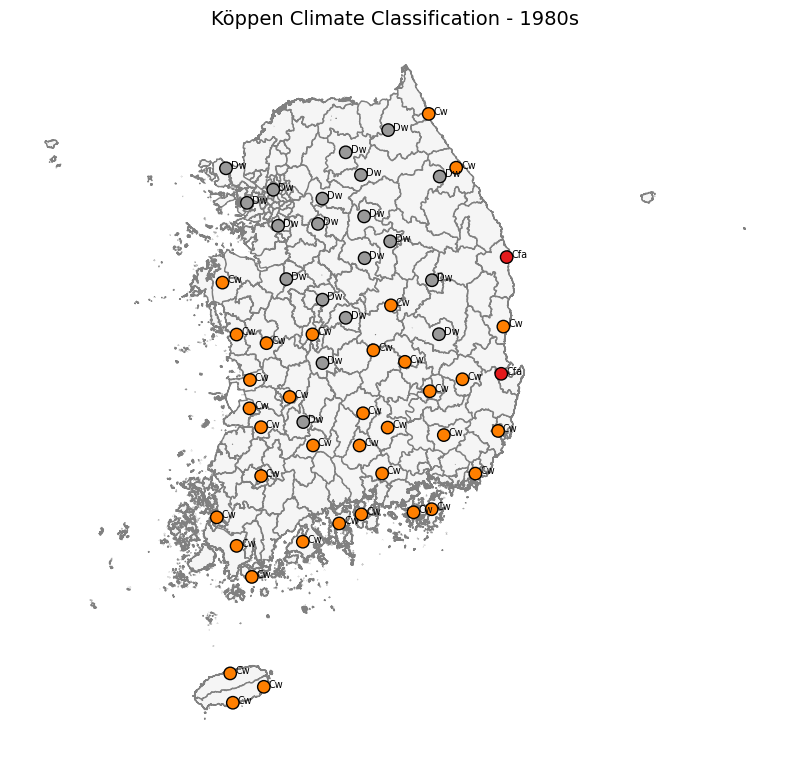

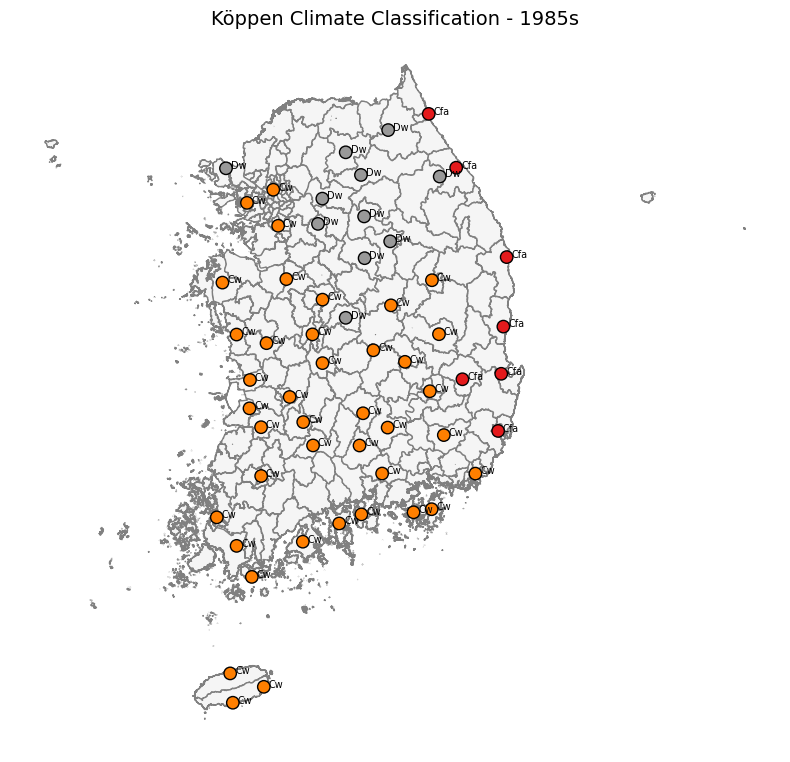

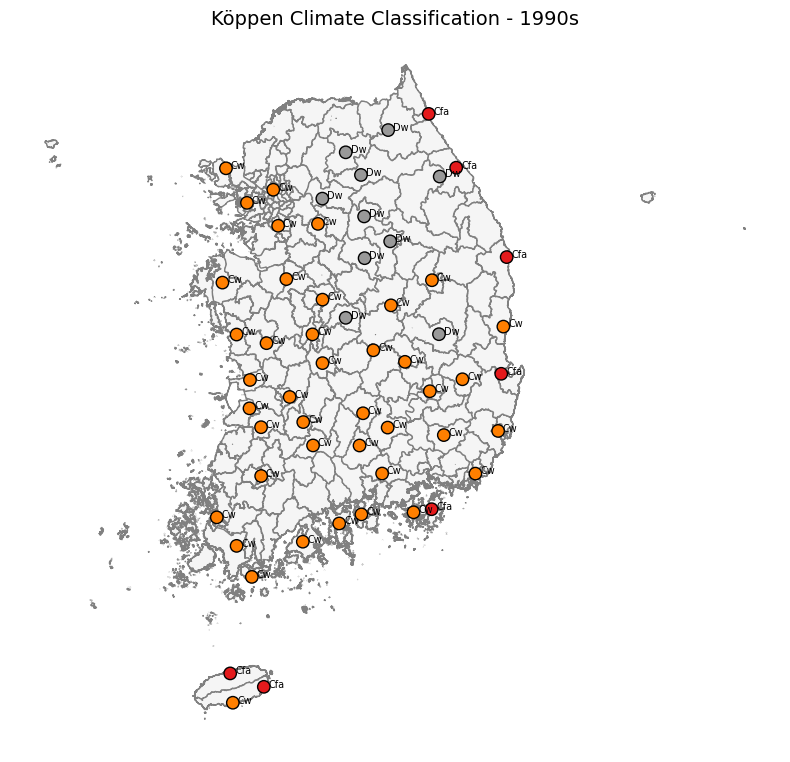

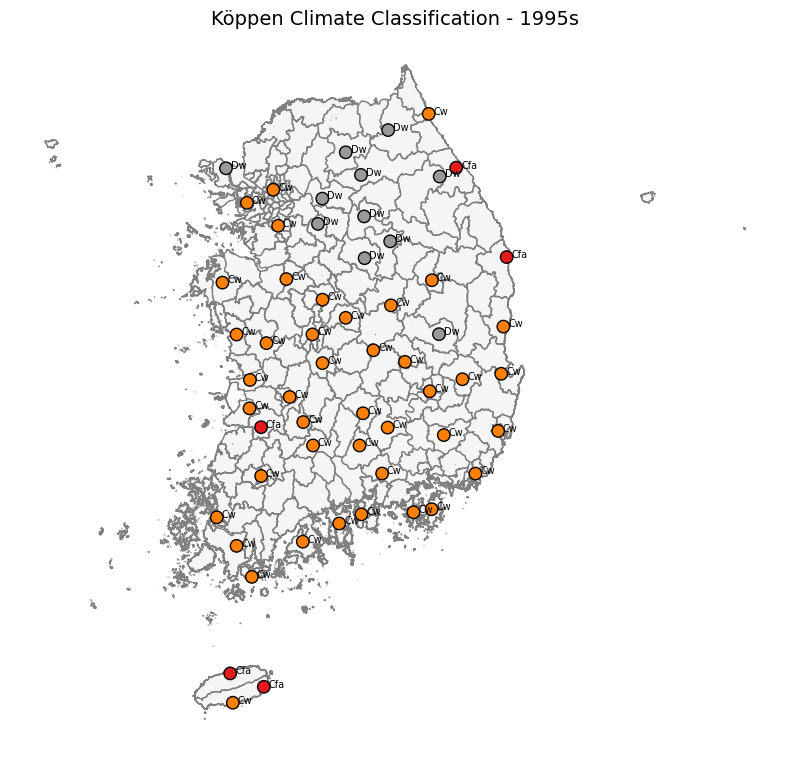

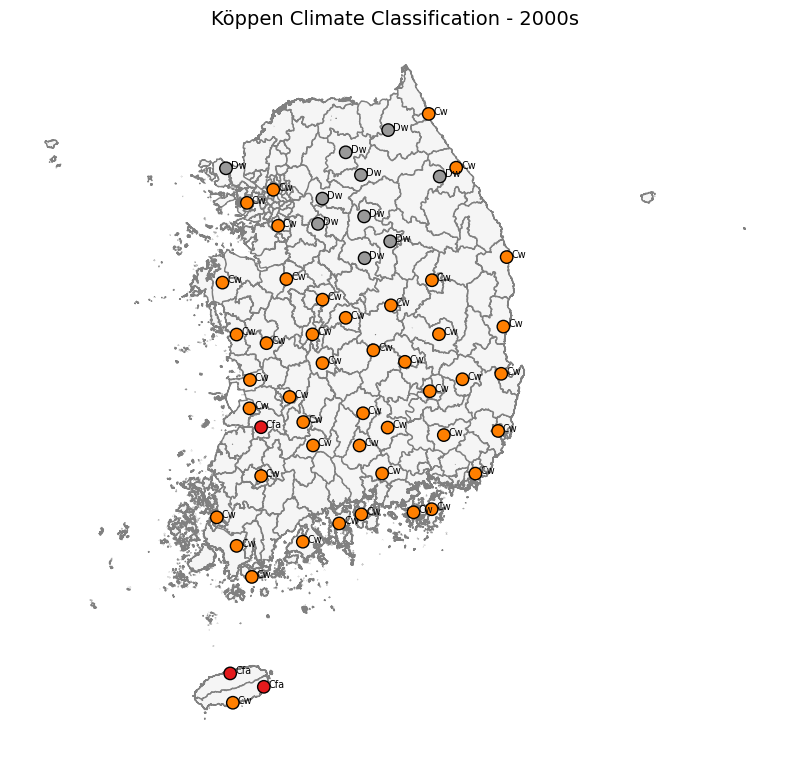

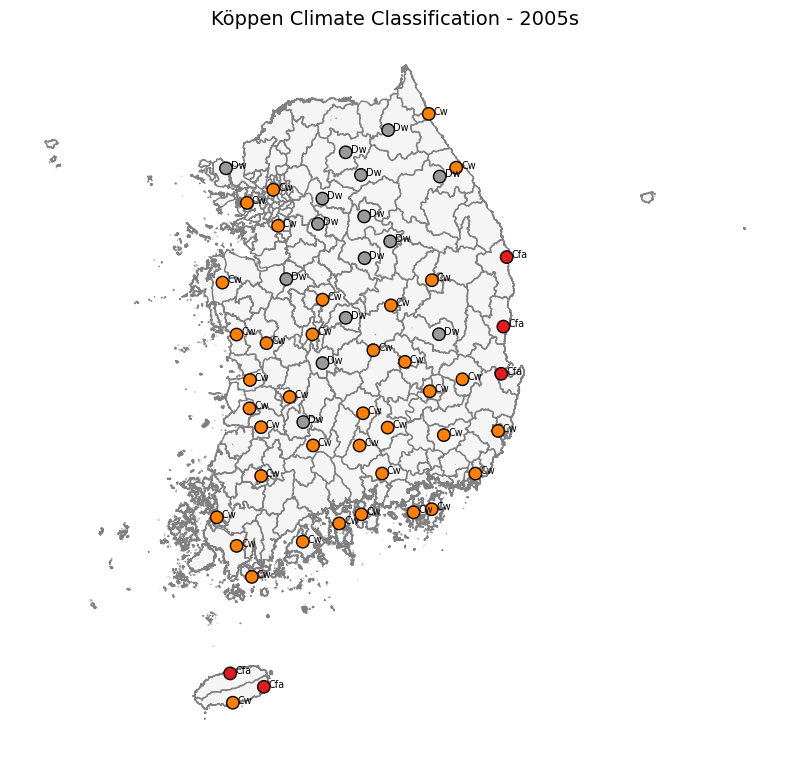

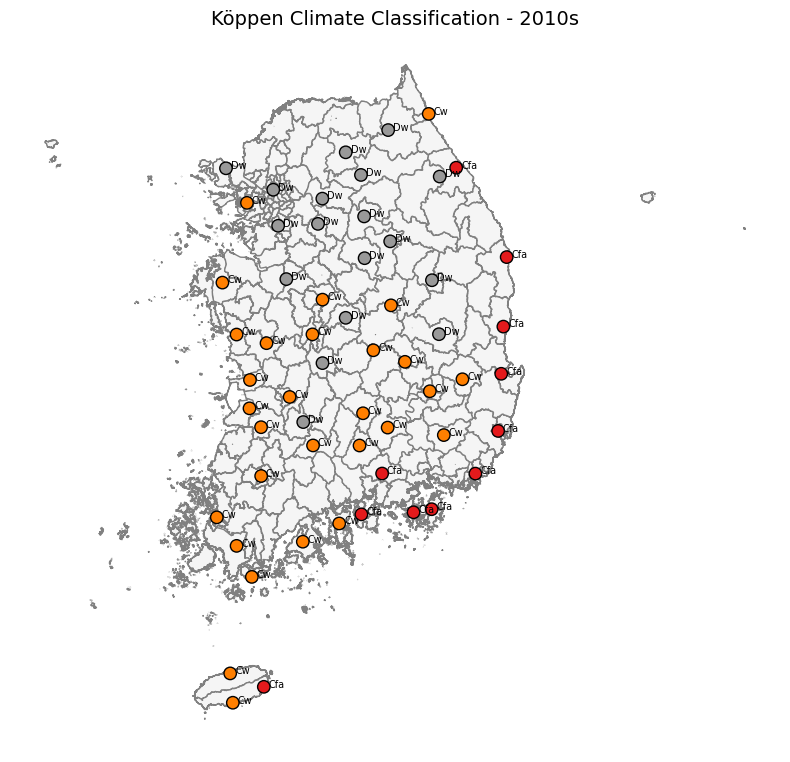

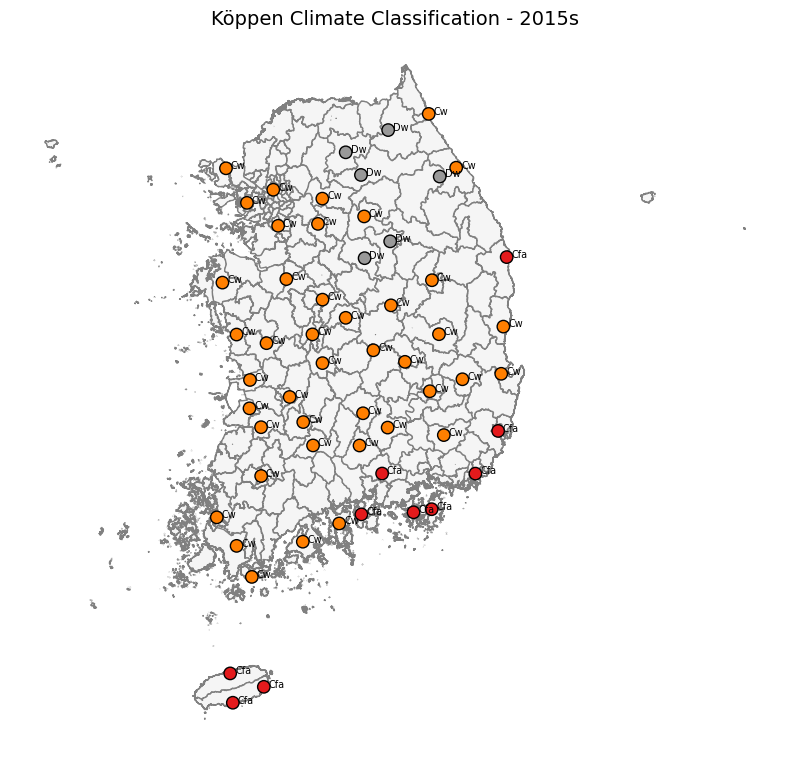

In [18]:
for period in periods:
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.set_title(f"Köppen Climate Classification - {period}", fontsize=14)

    # 배경 지도
    korea_map.plot(ax=ax, color='whitesmoke', edgecolor='gray')

    # 해당 시기의 기후 데이터만 선택
    sub_df = df[df['period'] == period]

    # 도시 점 찍기
    scatter = ax.scatter(
        sub_df['lon'], sub_df['lat'],
        c=sub_df['koppen'].astype('category').cat.codes,
        cmap='Set1',
        s=80, edgecolor='black'
    )

    # 라벨 표시
    for _, row in sub_df.iterrows():
        ax.text(row['lon'] + 0.05, row['lat'], row['koppen'], fontsize=7)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

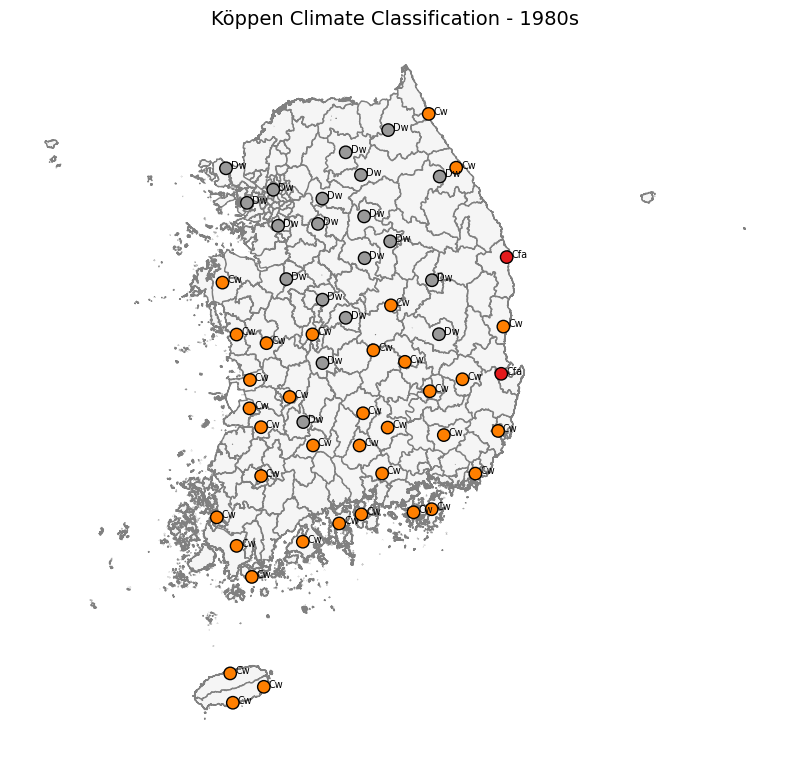

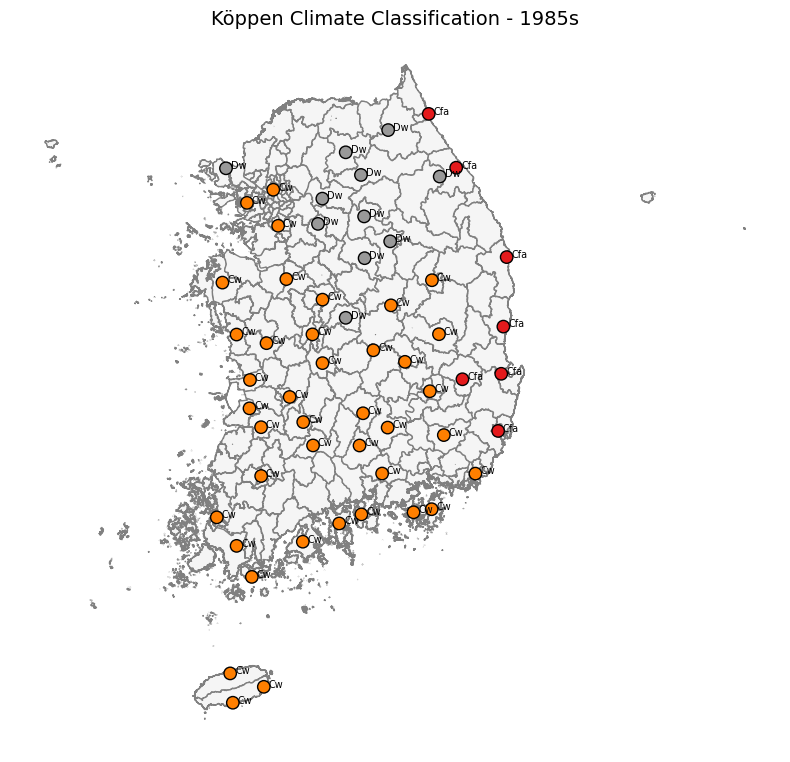

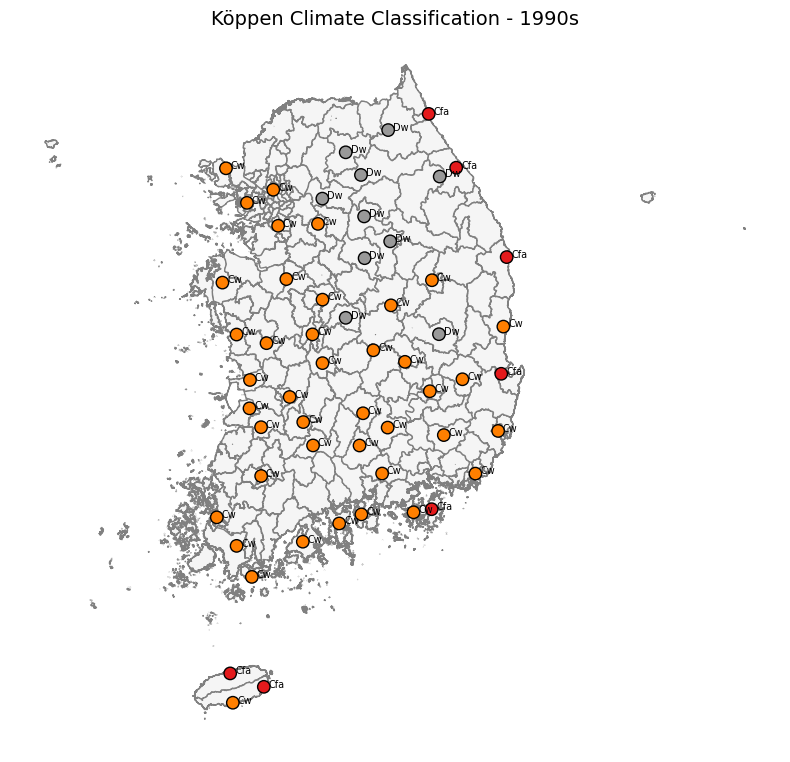

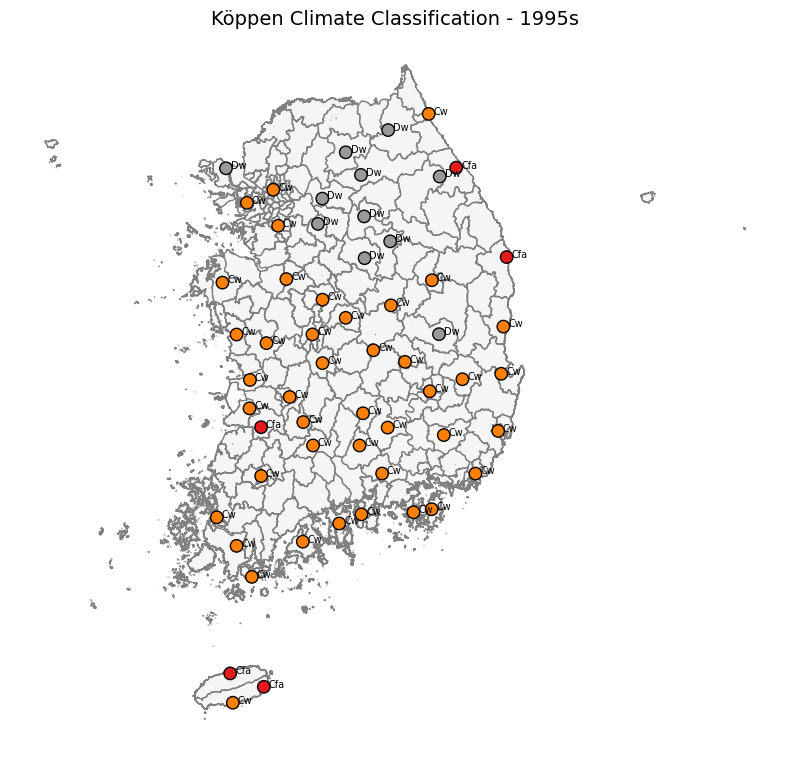

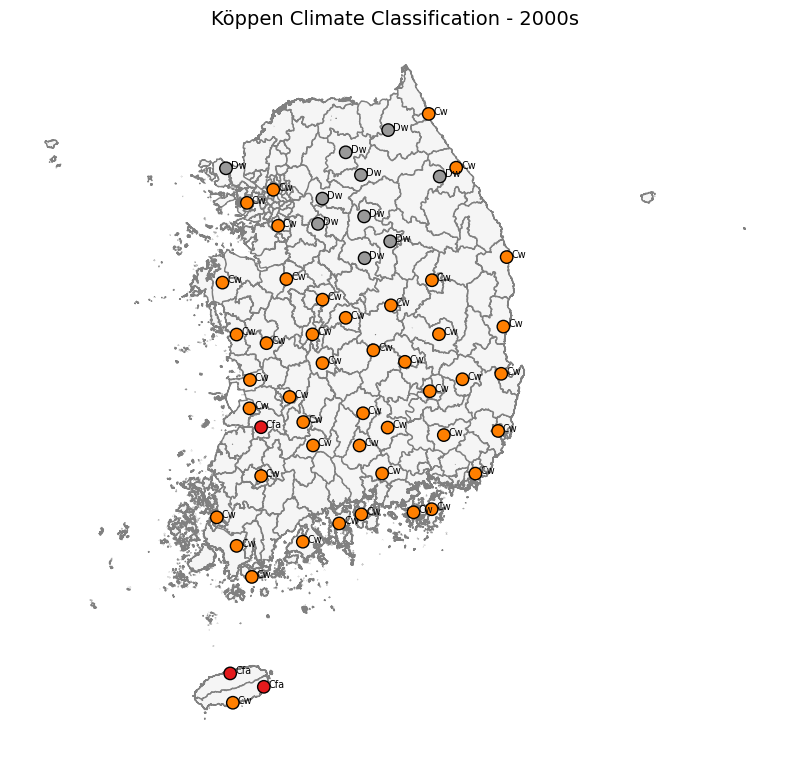

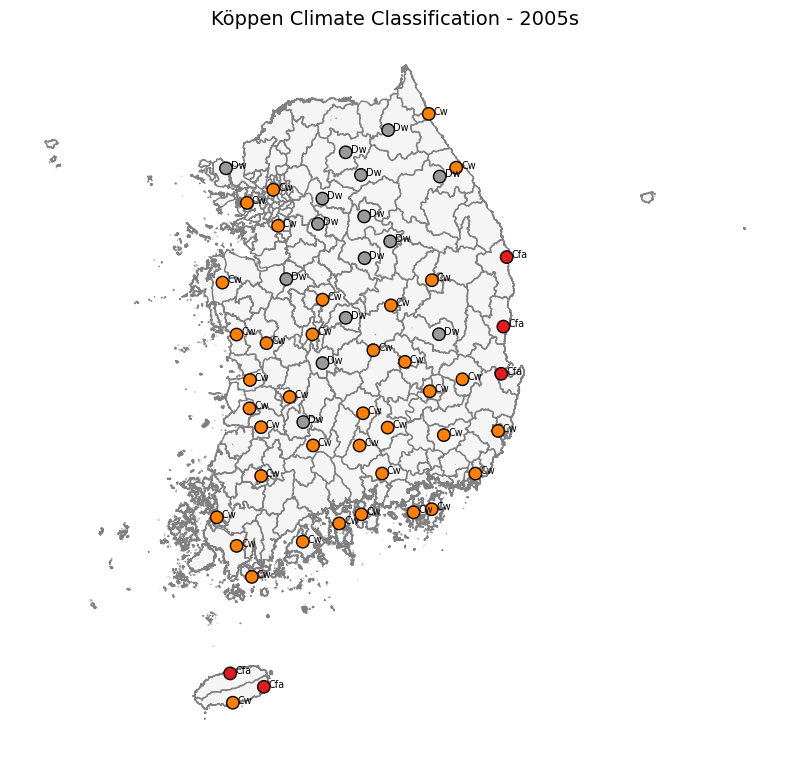

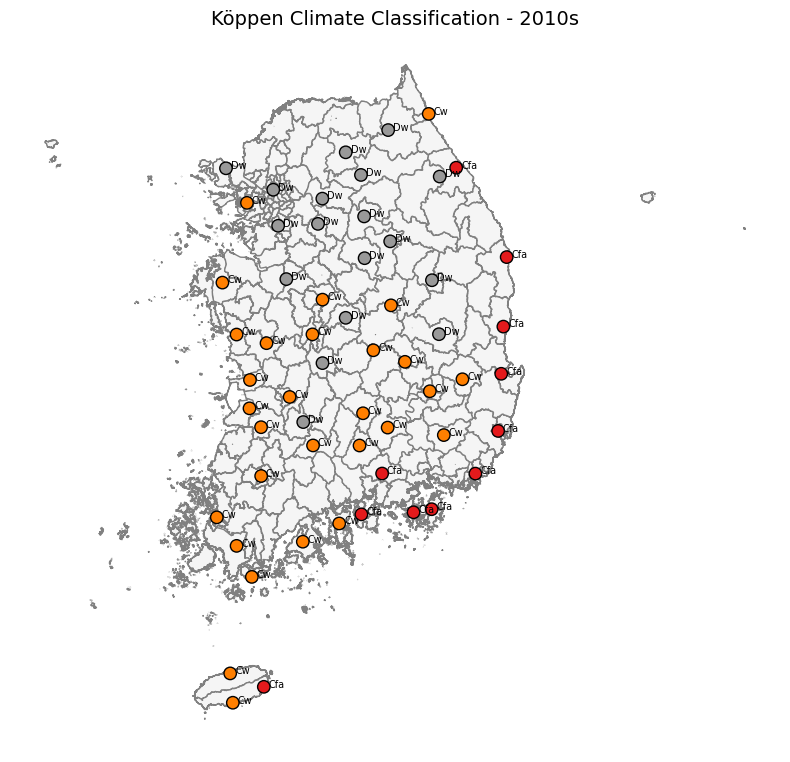

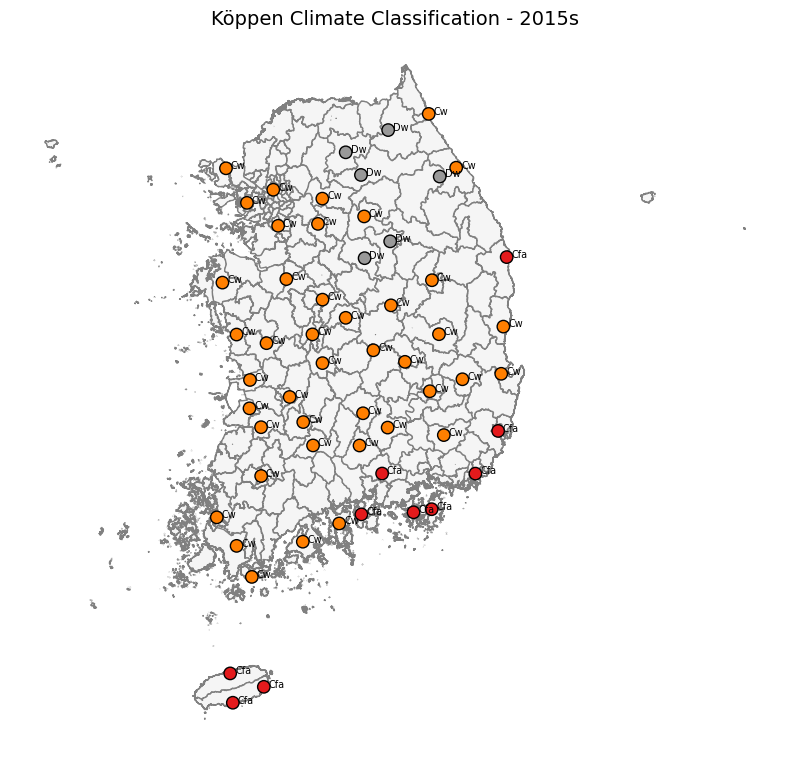

In [19]:
for period in periods:
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.set_title(f"Köppen Climate Classification - {period}", fontsize=14)

    korea_map.plot(ax=ax, color='whitesmoke', edgecolor='gray')

    sub_df = df[df['period'] == period]
    scatter = ax.scatter(
        sub_df['lon'], sub_df['lat'],
        c=sub_df['koppen'].astype('category').cat.codes,
        cmap='Set1',
        s=80, edgecolor='black'
    )

    for _, row in sub_df.iterrows():
        ax.text(row['lon'] + 0.05, row['lat'], row['koppen'], fontsize=7)

    ax.set_axis_off()
    plt.tight_layout()

    # 💾 이미지 파일 저장
    plt.savefig(f"Koppen_Climate_Map_{period}.png", dpi=300, bbox_inches='tight')

    plt.show()